In [92]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


### Create a StateGraph

'''
What is StateGraph?

At its core, StateGraph allows you to define your application as a graph where:

Nodes: These are the workhorses. Each node is a function or a LangChain Runnable (like an LLM call, a tool invocation, or a custom piece of logic). When the graph "visits" a node, that function gets executed.

Edges: These define how the application flows from one node to another. Critically, these transitions can be conditional, meaning the next step can be decided based on the output of the current node or the overall state.

State: This is the central, evolving piece of information that is passed between nodes. Each node can read from and write to this state. The state could be anything – a chat history, a dictionary of accumulated results, a plan, etc. It's how your application "remembers" things across different steps.
'''

In [93]:
class State(TypedDict):
    # Messages have the type list. The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

###  Add a node

In [94]:
import os
from dotenv import load_dotenv

load_dotenv()  # load environment variables from .env

# --- Environment Variable Checks ---
google_api_key_loaded = os.getenv("GOOGLE_API_KEY") is not None

print(f"Google API Key Loaded: {google_api_key_loaded}")

Google API Key Loaded: True


In [95]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gemini-2.0-flash", 
                        model_provider="google_genai",
                        temperature=0)
# model = init_chat_model(gemini-1.5-flash, model_provider=google_genai)

response = llm.invoke("Hello, world!")
print(response)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--f635d22f-eac9-44e6-b8b1-2b5c08101313-0' usage_metadata={'input_tokens': 4, 'output_tokens': 11, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}}


In [96]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [97]:
graph_builder.add_edge(START, "chatbot")

In [98]:
graph = graph_builder.compile()

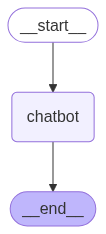

In [99]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [100]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User:" )
        print("User:"  + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User:"  + user_input)
        stream_graph_updates(user_input)
        break

User:hello
Assistant: Hello! How can I help you today?
User:what is capitalof indai
Assistant: The capital of India is **New Delhi**.
User:q
Goodbye!


### Tool calling

In [41]:
restaurants_data = {
        "Pizza": ["Dominos", "Pizza Hut", "Luigi's Pizzeria"],
        "Burger": ["McDonald's", "Burger King", "Shake Shack"],
        "Sushi": ["obu", "Sushi Samba", "Kura Sushi"],
        "Pasta": ["Olive Garden", "Carrabba's", "Maggiano's"],
        "Salad": ["Sweetgreen", "Chopt", "Saladworks"],
        "Ice Cream": ["Baskin Robbins", "Ben & Jerry's", "Cold Stone Creamery"]
}

print(restaurants_data["Pizza"])

['Dominos', 'Pizza Hut', "Luigi's Pizzeria"]


In [42]:
from langchain_core.tools import tool

@tool
def restaurant_search_tool(dish_name: str) -> str:
    """Searches for restaurants serving the given dish and returns a list of restaurants or a message if not found."""
    print(f"--- Tool: restaurant_search_tool called with dish: {dish_name} ---")
    # Simple case-insensitive search for the dish key
    found_restaurants = []
    for key_dish, restaurants_list in restaurants_data.items():
        if dish_name.lower() in key_dish.lower():
            found_restaurants.extend(restaurants_list)
    
    if found_restaurants:
        # Remove duplicates if a dish name matches multiple keys (e.g. if data had 'Pizza' and 'Gourmet Pizza')
        unique_restaurants = sorted(list(set(found_restaurants)))
        return f"The dish '{dish_name}' is available at: {', '.join(unique_restaurants)}."
    else:
        return f"Sorry, I couldn't find any restaurants serving '{dish_name}'."

In [45]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 2. Bind the tool to the LLM
# Ensure 'llm' is defined from the previous cell
llm_with_tools = llm.bind_tools([restaurant_search_tool])

In [46]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [47]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools=[restaurant_search_tool])

In [48]:
graph_builder.add_node("tools", tool_node)

In [49]:
from langgraph.graph import StateGraph, START, END


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

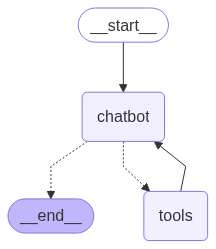

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [51]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User:", user_input)
        
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I help you today?
User: I want to order pizza
Assistant: 
--- Tool: restaurant_search_tool called with dish: pizza ---
Assistant: The dish 'pizza' is available at: Dominos, Luigi's Pizzeria, Pizza Hut.
Assistant: OK. I see that pizza is available at Dominos, Luigi's Pizzeria, and Pizza Hut.
User: order me the pizza
Assistant: I cannot order food for you. I can search for restaurants that serve pizza. Would you like me to do that?
User: q
Goodbye!


### Using 2 Tools

In [64]:
import os
from dotenv import load_dotenv

load_dotenv()  # load environment variables from .env

# --- Environment Variable Checks ---
google_api_key_loaded = os.getenv("GOOGLE_API_KEY") is not None
LANGSMITH_TRACING_LOADED = os.getenv("LANGSMITH_TRACING")

print(f"Google API Key Loaded: {google_api_key_loaded}")
print(f"LangSmith Tracing Loaded: {LANGSMITH_TRACING_LOADED}")

Google API Key Loaded: True
LangSmith Tracing Loaded: true


In [65]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gemini-2.0-flash", 
                        model_provider="google_genai",
                        temperature=0)
# model = init_chat_model(gemini-1.5-flash, model_provider=google_genai)

response = llm.invoke("Hello, world!")
print(response)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--fc5e72bd-f21e-4b9b-89de-4aa63c7eafdd-0' usage_metadata={'input_tokens': 4, 'output_tokens': 11, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}}


In [66]:
restaurants_data = {
        "Pizza": ["Dominos", "Pizza Hut", "Luigi's Pizzeria"],
        "Burger": ["McDonald's", "Burger King", "Shake Shack"],
        "Sushi": ["obu", "Sushi Samba", "Kura Sushi"],
        "Pasta": ["Olive Garden", "Carrabba's", "Maggiano's"],
        "Salad": ["Sweetgreen", "Chopt", "Saladworks"],
        "Ice Cream": ["Baskin Robbins", "Ben & Jerry's", "Cold Stone Creamery"]
}

print(restaurants_data["Pizza"])

['Dominos', 'Pizza Hut', "Luigi's Pizzeria"]


In [67]:
from langchain_core.tools import tool

@tool
def restaurant_search_tool(dish_name: str) -> str:
    """Searches for restaurants serving the given dish and returns a list of restaurants or a message if not found."""
    print(f"--- Tool: restaurant_search_tool called with dish: {dish_name} ---")
    # Simple case-insensitive search for the dish key
    found_restaurants = []
    for key_dish, restaurants_list in restaurants_data.items():
        if dish_name.lower() in key_dish.lower():
            found_restaurants.extend(restaurants_list)
    
    if found_restaurants:
        # Remove duplicates if a dish name matches multiple keys (e.g. if data had 'Pizza' and 'Gourmet Pizza')
        unique_restaurants = sorted(list(set(found_restaurants)))
        return f"The dish '{dish_name}' is available at: {', '.join(unique_restaurants)}."
    else:
        return f"Sorry, I couldn't find any restaurants serving '{dish_name}'."

In [68]:
import requests

@tool
def get_order_details_from_api(restaurant_name: str, dish_name: str) -> dict:
    """
    Calls the restaurant order API and returns the order details.

    Args:
        restaurant_name: The name of the restaurant.
        dish_name: The name of the dish ordered.

    Returns:
        A dictionary containing the order details, or None if an error occurs.
    """
    print(f"--- Tool: get_order_details_from_api called with restaurant_name: {restaurant_name} and dish_name: {dish_name}---")
    url = f"http://127.0.0.1:8000/orders/{restaurant_name}"
    params = {"dish_name": dish_name}

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling the API: {e}")
        if response.status_code == 404:
            print(f"Restaurant or dish not found: {response.json().get('detail', 'Unknown error')}")
        return None

In [69]:
# Adding a Human-in-the-loop tool

from langgraph.types import interrupt

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    print(f"--- Tool: human_assistance called with query: {query} ---")
    human_response = interrupt({"query": query})
    if human_response["data"]:
        return human_response["data"]
    else:
        return "Assistance requested but no input received."

In [70]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 2. Bind the tool to the LLM
# Ensure 'llm' is defined from the previous cell

tools_list = [restaurant_search_tool, 
              get_order_details_from_api, 
              human_assistance]
llm_with_tools = llm.bind_tools(tools_list)

In [71]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [72]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools_list)

In [73]:
graph_builder.add_node("tools", tool_node)

In [74]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

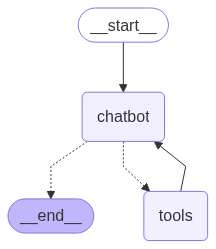

In [75]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [79]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User:", user_input)
        
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I help you today?
User: I want to eat pizza
Assistant: 
--- Tool: restaurant_search_tool called with dish: pizza ---
Assistant: The dish 'pizza' is available at: Dominos, Luigi's Pizzeria, Pizza Hut.
Assistant: OK. pizza is available at Dominos, Luigi's Pizzeria, and Pizza Hut. Which restaurant would you like to order from?
User: Order pizza from Dominos
Assistant: 
--- Tool: get_order_details_from_api called with restaurant_name: Dominos and dish_name: pizza---
Assistant: {"order_id": "375f9514-7637-4ab4-bd4a-fa1295e74976", "restaurant_name": "Dominos", "items": ["pizza"], "total_amount": 12.62, "currency": "USD", "ordered_at": "2025-05-20T16:25:12.480713", "estimated_arrival_time": "2025-05-20T16:47:12.480713", "payment_mode": "Cash on Delivery", "status": "Order Placed", "delivery_address": "123 Main St, Anytown, USA", "customer_notes": null}
Assistant: OK. I have placed an order for pizza from Dominos. The order details are:  Order ID: 375f9514

### Adding Memory

In [81]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# This is in-memory checkpointer, which is convenient for the tutorial. However, in a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect a database.

In [82]:
graph = graph_builder.compile(checkpointer=memory)

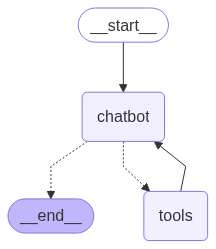

In [83]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [84]:
config = {"configurable": {"thread_id": "1"}}

In [85]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]},
                              config,):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User:", user_input)
        
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I help you today?
User: i want to eat pizza
Assistant: 
--- Tool: restaurant_search_tool called with dish: pizza ---
Assistant: The dish 'pizza' is available at: Dominos, Luigi's Pizzeria, Pizza Hut.
Assistant: OK. I found pizza at Dominos, Luigi's Pizzeria, and Pizza Hut. Which restaurant would you like to order from?
User: Order from Dominos
Assistant: 
--- Tool: get_order_details_from_api called with restaurant_name: Dominos and dish_name: pizza---
Assistant: {"order_id": "9d1f9bb2-5130-43ad-b08f-60c9f32cd42d", "restaurant_name": "Dominos", "items": ["pizza"], "total_amount": 12.54, "currency": "USD", "ordered_at": "2025-05-20T16:28:20.718249", "estimated_arrival_time": "2025-05-20T17:17:20.718249", "payment_mode": "Debit Card", "status": "Delivered", "delivery_address": "123 Main St, Anytown, USA", "customer_notes": "Call upon arrival."}
Assistant: OK. I have an order from Dominos for pizza. The order details are:
*   Order ID: 9d1f9bb2-5130-43

In [86]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (511f51e5-6c0a-4fb2-bf6a-74d7ec2dbd5d)
 Call ID: 511f51e5-6c0a-4fb2-bf6a-74d7ec2dbd5d
  Args:
    query: I need some expert guidance for building an AI agent.
--- Tool: human_assistance called with query: I need some expert guidance for building an AI agent. ---


#### Check the state

In [87]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='8e5a4a01-cc99-4621-89da-b7300f26d13b'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--31d728f1-cc11-42f4-9a49-ae1aa83be217-0', usage_metadata={'input_tokens': 130, 'output_tokens': 10, 'total_tokens': 140, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='i want to eat pizza', additional_kwargs={}, response_metadata={}, id='ba8dda58-8168-43f9-8650-ef42bbb3114a'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'restaurant_search_tool', 'arguments': '{"dish_name": "pizza"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='ru

In [88]:
snapshot.next  
# (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

('tools',)

In [89]:
# Resume execution

from langgraph.types import Command

human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (511f51e5-6c0a-4fb2-bf6a-74d7ec2dbd5d)
 Call ID: 511f51e5-6c0a-4fb2-bf6a-74d7ec2dbd5d
  Args:
    query: I need some expert guidance for building an AI agent.
--- Tool: human_assistance called with query: I need some expert guidance for building an AI agent. ---
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

OK. The experts recommend that you check out LangGraph to build your agent. They say it's much more reliable and extensible than simple autonomous agents.
